Пока в работе

####1. Попробуйте изменить параметры нейронной сети, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) или любым любимым временным рядом так, чтобы улучшить её точность. Приложите анализ

In [3]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import datetime

In [4]:
%load_ext tensorboard

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [6]:
files.upload()
!ls

Saving PJME_Потребление_энергии_D.csv to PJME_Потребление_энергии_D.csv
PJME_Потребление_энергии_D.csv	sample_data


In [7]:
#df = pd.read_csv('my_BRENT2019.csv')
df = pd.read_csv('/content/PJME_Потребление_энергии_D.csv')
df.index = df.Date
df.drop(['Date'],axis=1,inplace = True)

In [8]:
df.head()

,PJME_MW
Date,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0


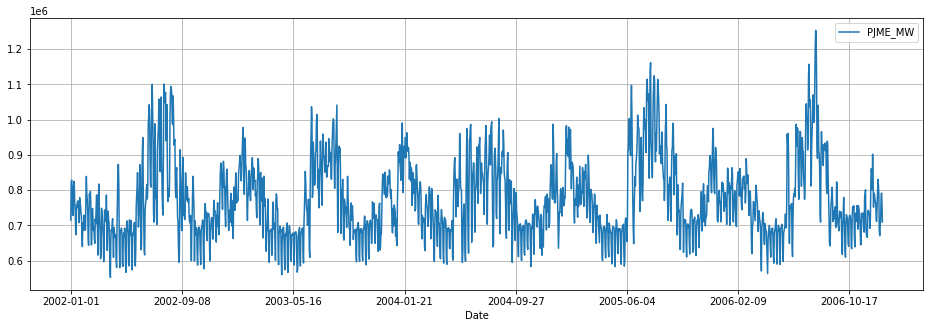

In [9]:
df.plot( figsize = (16,5))
#df['PJME_MW'].plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [10]:
df.describe()

,PJME_MW
count,1.825000e+03
mean,7.738672e+05
std,1.115791e+05
min,5.519940e+05
25%,6.948500e+05
50%,7.531920e+05
75%,8.391540e+05
max,1.253516e+06


In [11]:
#data = df.iloc[1500:,1:]  # BRENT убираем данные до 2015 года , т.к. сильно изменилось поведение и дату-время, т.к. она дублирована другими признаками
data = df.copy() # берем все что есть

In [13]:
data.shape[1]

1

In [14]:
data.head()

,PJME_MW
Date,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0


Делаем нормализацию

In [17]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

Можно (и нужно заменять на sklearn StandadScaler) т.к. это нужно дополнительно сохранять для обработки реальных данных , но тут сделаем без привлечения внешних модулей

In [19]:
train_split = 1000
data_v =  normalize(data.values, train_split)
data_f = pd.DataFrame(data_v)

Создаем данные для обучения

In [24]:
# список признаков, по которым будем учить
#channelIndexes = [0, 1, 2, 3] # BRENT
channelIndexes = [0]

# длина теста
valLen = 100
# длина истории для работы
xLen = 30
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
#train_split = data_f.shape[0] - valLen - bias
# делим
train_data = data_f.iloc[0: train_split, channelIndexes]
val_data = data_f.iloc[train_split+bias:, channelIndexes]

In [25]:
train_data.head(7)

,0
0,-0.493448
1,0.508508
2,0.564548
3,0.386262
4,-0.354786
5,-0.373040
6,0.300832


Формируем параметры для генерации выборки

In [28]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 10

####2. Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения